**Mixed model**

Import libraries

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

Load and view aquastat data set

In [118]:
df = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/ultimate+aquastat+(flat).csv')  # will be used for Time series analysis
df_GDP = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/GDP.csv')

In [119]:
table = pd.pivot_table(data=df,values='Value',index=['Area','Year'],columns='Variable Name')
df=pd.DataFrame(table.to_records())
df.head(20)

,Area,Year,Agricultural water withdrawal as % of total renewable water resources,"Agriculture, value added (% GDP)",Average Temperature,Environmental Flow Requirements,GDP per capita,"Industry, value added to GDP",Long-term average annual precipitation in volume,MDG 7.5. Freshwater withdrawal as % of total renewable water resources,...,Prevalence of undernourishment (3-year average),SDG 6.4.1. Industrial Water Use Efficiency,SDG 6.4.1. Irrigated Agriculture Water Use Efficiency,SDG 6.4.1. Services Water Use Efficiency,SDG 6.4.1. Water Use Efficiency,SDG 6.4.2. Water Stress,"Services, value added to GDP",Total population with access to safe drinking-water (JMP),Total renewable water resources per capita,Total water withdrawal per capita
0,Afghanistan,1992.0,35.498101,54.207106,12.61,28.29,248.518890,5.530000e+08,213.48522,35.910480,...,29.5,25.311413,0.092143,10.237171,0.240400,63.337788,9.950000e+08,21.3,4510.012947,1619.567311
1,Afghanistan,1997.0,31.427856,62.416768,12.86,28.29,164.092893,4.220000e+08,213.48522,31.852952,...,45.6,9.091408,0.085820,7.763338,0.194590,56.181246,6.530000e+08,25.0,3374.984489,1075.032191
2,Afghanistan,2002.0,30.613807,45.134344,13.91,28.29,194.958382,9.150000e+08,213.48522,31.045461,...,47.8,11.426285,0.074770,15.252615,0.285607,54.757019,1.470000e+09,33.8,2890.609479,899.030431
3,Afghanistan,2007.0,30.613807,35.265942,13.80,28.29,389.985586,2.600000e+09,213.48522,31.045461,...,33.3,20.815284,0.110353,26.876683,0.549846,54.757019,4.030000e+09,42.6,2410.653428,751.752659
4,Afghanistan,2012.0,30.613807,28.556142,13.25,28.29,694.885618,4.360000e+09,213.48522,31.045461,...,24.7,23.227115,0.103801,47.639557,0.770774,54.757019,1.070000e+10,51.6,2096.505623,653.786919
5,Afghanistan,2017.0,30.613807,25.574670,13.12,28.29,605.557362,4.500000e+09,213.48522,31.045461,...,22.2,27.851985,0.118946,56.384791,0.911431,54.757019,1.090000e+10,55.3,1799.917253,561.297018
6,Afghanistan,2018.0,30.613807,22.440899,14.55,28.29,563.983834,4.800000e+09,213.48522,31.045461,...,23.0,31.220059,0.102132,57.683901,0.935917,54.757019,1.060000e+10,55.3,1757.509385,548.072294
7,Argentina,1992.0,NaN,5.193747,14.37,515.80,7366.759988,6.080000e+10,1643.00000,3.243937,...,NaN,NaN,NaN,NaN,NaN,7.886104,1.580000e+11,94.3,26133.540530,847.773175
8,Argentina,1997.0,2.455948,4.527197,15.14,515.80,8861.217104,6.800000e+10,1643.00000,3.343179,...,NaN,29.856348,0.080770,55.788386,12.184452,8.127364,1.940000e+11,95.6,24573.841260,822.584545
9,Argentina,2002.0,2.588954,8.848660,14.60,515.80,2918.591423,2.760000e+10,1643.00000,3.617493,...,3.0,22.932637,0.109619,39.086531,9.249703,8.794229,6.060000e+10,96.7,23253.697700,843.627906


In [120]:
# drop undernourishment and add GDP  
df = df.drop('Prevalence of undernourishment (3-year average)', axis=1)  # TODO download correct data from AQUASTAT instead of dropping here
table_GDP = pd.pivot_table(data=df_GDP,values='Value',index=['Area','Year'],columns='Variable Name')
df_GDP=pd.DataFrame(table_GDP.to_records())
df_GDP

,Area,Year,Gross Domestic Product (GDP)
0,Afghanistan,1992.0,3.444711e+09
1,Afghanistan,1997.0,2.924589e+09
2,Afghanistan,2002.0,4.141524e+09
3,Afghanistan,2007.0,9.412162e+09
4,Afghanistan,2012.0,1.913650e+10
...,...,...,...
254,Zimbabwe,2002.0,8.215468e+09
255,Zimbabwe,2007.0,6.958295e+09
256,Zimbabwe,2012.0,1.711485e+10
257,Zimbabwe,2017.0,2.204090e+10


In [121]:
df = df.merge(df_GDP, how='inner', on=['Area','Year'])

In [122]:
df.rename(columns = {'SDG 6.4.2. Water Stress':'WaterStress'}, inplace = True)

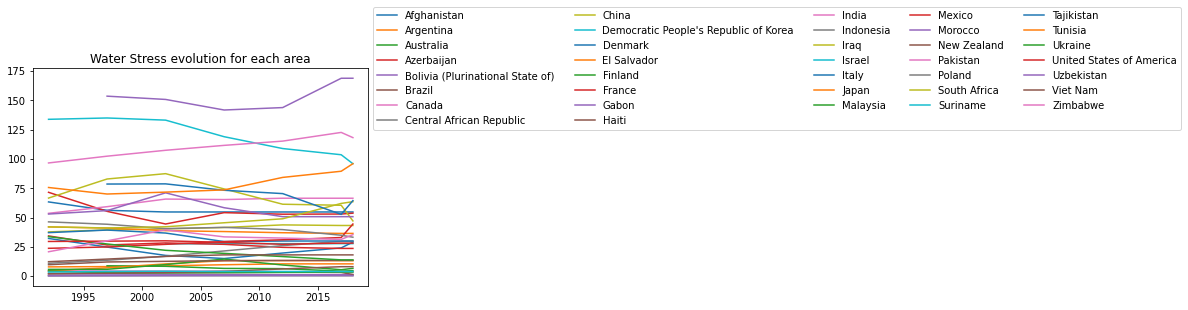

In [123]:
start_idx = 0
while int(len(df)) != start_idx:
    plt.plot([1992, 1997, 2002, 2007, 2012, 2017,2018], df.loc[start_idx:(start_idx+6), ['WaterStress']])
    start_idx += 7
plt.title('Water Stress evolution for each area')
plt.legend(df['Area'].unique(),loc='center left', bbox_to_anchor=(1, 1),
          ncol=5, fancybox=True, shadow=False)
plt.show()

Area starts with high water stress tends to have high water stress in later observation. So there is high intra-area correlation between the observations. The trend of evolution for most of these ares are similar, therefore a mixed model with random intercept may be sufficient to take the intra-area correlation into account.

In [124]:
df['Industry, value added (% GDP)']=df['Industry, value added to GDP']/df['Gross Domestic Product (GDP)']*100
df['Services, value added (% GDP)']=df['Services, value added to GDP']/df['Gross Domestic Product (GDP)']*100

In [125]:
df.isnull().sum()

Area                                                                       0
Year                                                                       0
Agricultural water withdrawal as % of total renewable water resources      7
Agriculture, value added (% GDP)                                           0
Average Temperature                                                        4
Environmental Flow Requirements                                            0
GDP per capita                                                             0
Industry, value added to GDP                                               0
Long-term average annual precipitation in volume                           0
MDG 7.5. Freshwater withdrawal as % of total renewable water resources     5
National Rainfall Index (NRI)                                              7
Population density                                                         0
SDG 6.4.1. Industrial Water Use Efficiency                                 8

In [126]:
df.dropna(inplace=True)

In [127]:
df.columns = df.columns.str.replace('%', 'per')
df.columns = df.columns.str.replace(',', '')
df.columns = df.columns.str.replace('(', '')
df.columns = df.columns.str.replace(')', '')
df.columns = df.columns.str.replace('.', '')
df.columns = df.columns.str.replace(' ', '_')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


In [128]:
df['Year']=df['Year']-1992

##collinearity check

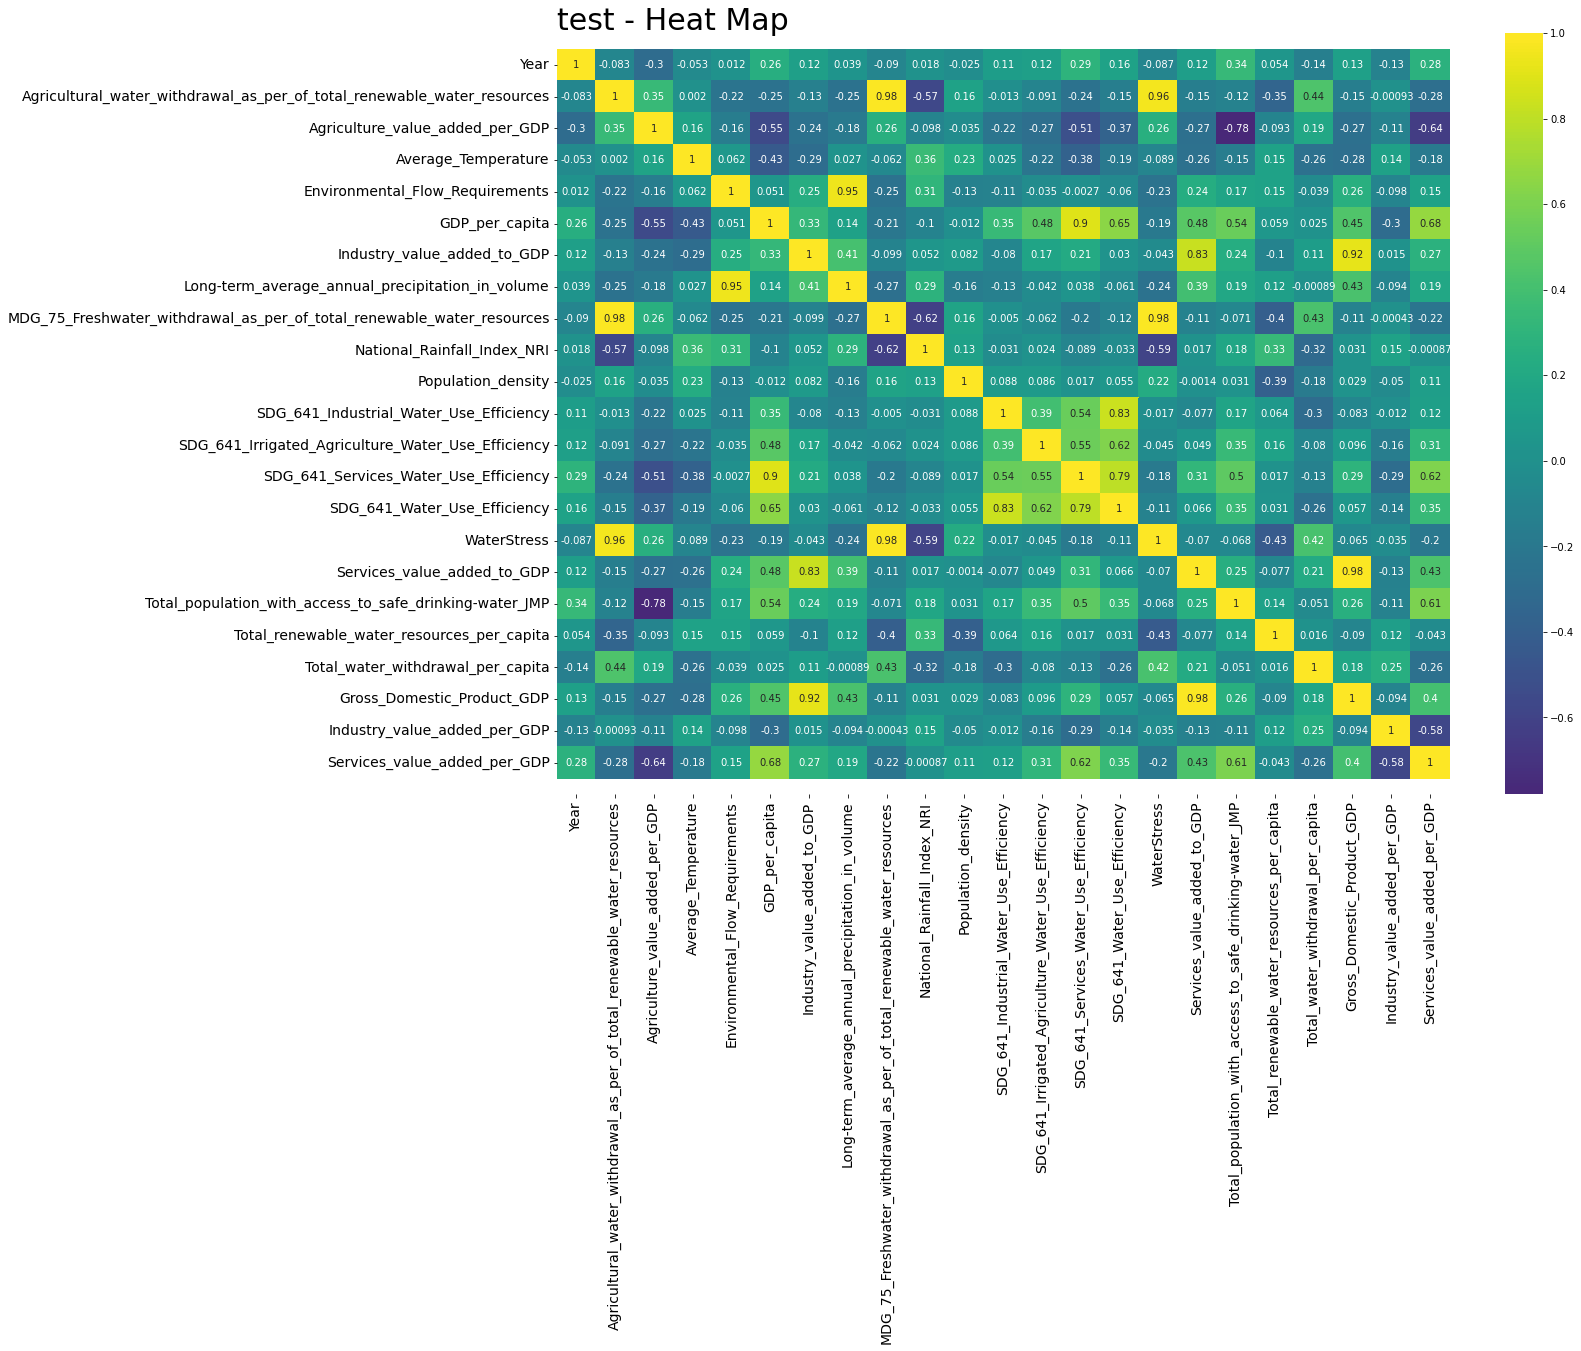

In [129]:
plt.figure(figsize=(20,14))
ax = sns.heatmap(df.corr(), cmap='viridis', center=0, annot=True)
bottom, top = ax.get_ylim()
plt.text(0,-0.6, "test - Heat Map", fontsize = 30, color='Black', fontstyle='normal')
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.show()

 For covariates with high correlation, only one is included to avoid multicollinearity.

In [130]:
md = smf.mixedlm("WaterStress ~ Year+Average_Temperature+Environmental_Flow_Requirements+GDP_per_capita+National_Rainfall_Index_NRI", df, groups=df["Area"])
mdf = md.fit()
print(mdf.summary())

                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       WaterStress
No. Observations:        208           Method:                   REML       
No. Groups:              36            Scale:                    37.7274    
Min. group size:         3             Likelihood:               -776.2265  
Max. group size:         7             Converged:                Yes        
Mean group size:         5.8                                                
----------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025  0.975]
----------------------------------------------------------------------------
Intercept                        78.961   11.892  6.640 0.000 55.653 102.269
Year                              0.108    0.066  1.621 0.105 -0.023   0.238
Average_Temperature              -1.190    0.669 -1.780 0.075 -2.501   0.121
Environmental_Flow_

the intraclass correlation coefficient (ICC) which measures the similarity of the responses within a random effect; in the current model with 1 cluster variable, this would be the similarity in water stress within the area. The ICC can range between 0 - 1 where 1 indicates perfect relationship within the clusters. To calculate the ICC one takes the variance of the clustering variable  and divides it by the unexplained variance of the model . The unexplained variance of the model can be found in the top right of the upper table labeled "scale".
From the result, the intra-area correlation is 993.503/(993.503+37.727^2)=0.411. GDP_per_capita,National_Rainfall_Index_NRI are important factors in predicting water stress. 

# Outlier detection

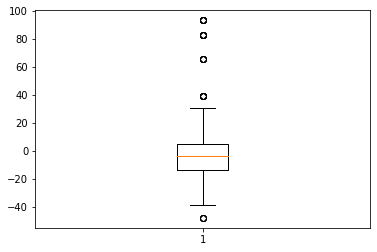

In [131]:
area_specific_intercept=df['Area'].apply(lambda x: mdf.random_effects[x])
area_specific_intercept['Area']=df['Area']
area_specific_intercept
plt.boxplot(area_specific_intercept['Group'])
plt.show()

In [132]:
df2=pd.DataFrame()
df2['intercept']=area_specific_intercept['Group'].unique()
df2['area']=df['Area'].unique()
df2

,intercept,area
0,-4.684070,Afghanistan
1,-31.528333,Argentina
2,-8.860615,Australia
3,-0.910116,Azerbaijan
4,-28.908460,Bolivia (Plurinational State of)
5,-13.304150,Brazil
6,-47.861629,Canada
7,-27.948415,Central African Republic
8,-11.303552,China
9,-8.100092,Denmark


In [133]:
def find_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [134]:
upper_boundary, lower_boundary = find_boundaries(df2, 'intercept', 1.5)
upper_boundary, lower_boundary

(28.134843987878913, -43.127057721629214)

In [135]:
outliers = np.where(df2['intercept'] > upper_boundary, True,
            np.where(df2['intercept'] < lower_boundary, True, False))
outliers_df = df2.loc[outliers, 'area']
outliers_df
df2.loc[outliers,]

,intercept,area
6,-47.861629,Canada
15,39.398738,India
18,82.345795,Israel
25,65.212180,Pakistan
30,30.705449,Tunisia
33,93.199421,Uzbekistan


These countries have area-specific intercepts which deviates much from the mean evolution. 

## Reference

Statsmodels.Regression.Mixed_linear_model.MixedLM — Statsmodels. https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html. Accessed 7 June 2022.